In [1]:
import pandas as pd
import requests as r
import matplotlib.pyplot as plt
from urllib.request import urlopen as uReq
import bs4
from bs4 import BeautifulSoup as soup
import re
import numpy as np
from google_play_scraper import Sort, reviews, app
from tqdm import tqdm
import json
import seaborn as sns
from pygments import highlight
from pygments.lexers import JsonLexer
from pygments.formatters import TerminalFormatter
from wordcloud import WordCloud
import nltk
#nltk.download('punkt')
#nltk.download('brown')
pd.options.mode.chained_assignment = None 
import tkinter
import time
import datetime as dt
from textblob import TextBlob
import unicodedata, re, string
import plotly.express as px
#matplotlib.use('TkAgg')
import pandasql as ps
from pandasql import sqldf
pd.set_option("max_colwidth",None)



In [2]:
app_packages = ['com.soundtrap.studioapp']


In [3]:
#Scraping
app_infos = []
for ap in tqdm(app_packages):
  info = app(ap, lang='es', country='es')
  del info['comments']
  app_infos.append(info)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.28it/s]


In [4]:
def print_json(json_object):
  json_str = json.dumps(
    json_object,
    indent=2,
    sort_keys=True,
    default=str
  )
  print(highlight(json_str, JsonLexer(), TerminalFormatter()))

In [5]:
#print_json(app_infos[0])

In [6]:
#scraped data into dataframe
app_infos_df = pd.DataFrame(app_infos)
#app_infos_df
app_infos_df.histogram

0    [1536, 508, 958, 1786, 6805]
Name: histogram, dtype: object

In [7]:
#app_infos_df.keys()

In [8]:
#Scraping
eng_reviews=  []
for ap in tqdm(app_packages):
  for score in list(range(1, 6)):
    for sort_order in [Sort.MOST_RELEVANT, Sort.NEWEST]:
      rvs, _ = reviews(
        ap,
        #lang='en',
        #country='us',
        sort=sort_order,
        #count= 200 if score == 3 else 100
        count= 1000000,
        filter_score_with=score
      )
      for r in rvs:
        r['appId'] = ap
      eng_reviews.extend(rvs)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:16<00:00, 16.40s/it]


# Now that the data is imported, I will proceed with checking for duplicates and creating new columns for the first analysis

In [9]:
#Scraped data into dataframe
df_eng_reviews = pd.DataFrame(eng_reviews)
#df_eng_reviews.head()

In [10]:
#checking the duplicates
df_eng_reviews = df_eng_reviews.drop_duplicates()
#len(df_eng_reviews)
len(df_eng_reviews)

4421

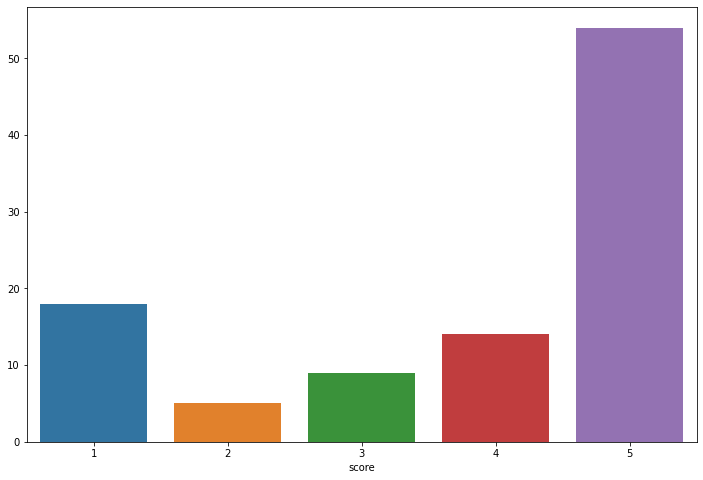

In [11]:
score_barplot = df_eng_reviews.groupby(["score"]).size()#sentiment distribution 
percent= round(score_barplot/df_eng_reviews['score'].count()*100)
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(score_barplot.keys(), percent.values)

In [12]:
#changing format from string to datetime 
df_eng_reviews['at'] = pd.to_datetime(df_eng_reviews['at'], errors='coerce')
#df_eng_reviews

In [13]:
#date_trunc('day')
df_eng_reviews['date'] = df_eng_reviews['at'].apply(lambda x: x.replace(day= 1, hour=0,minute=0, second=0))
df_eng_reviews['date'] = pd.to_datetime(df_eng_reviews['date'], format='%Y/%m/%d')
#df_eng_reviews.info()

In [14]:
#final dataframe with the new day, month and year column added
df= df_eng_reviews[['userName','at','score','thumbsUpCount','content','date']]
df['month'] = df['at'].dt.to_period('M')
df['year'] = df['at'].dt.to_period('Y')
df['day'] = df['at'].dt.to_period('D')
df['DoW'] = df['day'].dt.dayofweek
#df.reset_index=True
#df

In [15]:
#line plot from excel
#df.to_excel (r'all history.xlsx', index = False, header=True)

In [16]:
avg_score = sqldf("select date, avg(score) as score from df_eng_reviews group by date")
avg_score['month']= pd.to_datetime(avg_score['date'], format='%Y/%m/%d')
avg_score['year'] = avg_score['month'].dt.to_period('Y')
#avg_score_calc = avg_score.groupby(['year'])['score'].mean().reset_index()
avg_score['total_mean']=avg_score.score.mean()

#avg_score

In [17]:
score_per_month_number = sqldf("select date, score, count(*) as number from df_eng_reviews where score = 1 or score = 5 group by date, score order by date, score asc")
#score_per_month_number

In [18]:
import plotly.graph_objects as go
fig1 = go.Figure(data=go.Scatter(x=avg_score["month"], y=avg_score["score"],mode='lines+markers'))
fig1.add_trace(go.Scatter(x=avg_score["month"], y=avg_score['total_mean'], name='mean',
                         line=dict(color='red', width=4, dash='dot')))
fig1.show()

In [19]:
fig2 = px.line(score_per_month_number, x="date", y="number", color="score",title="Score 5 vs 1"
              )
fig2.show()


In [20]:
posVSneg = sqldf("select case when score < 4 then 'negative' else 'positive' end as posVSneg from df_eng_reviews")
#posVSneg
#round(posVSneg.posVSneg.value_counts()/len(posVSneg)*100).plot(kind='bar')
posVSneg2= sqldf("select date, case when score < 4 then 'negative' else 'positive' end as posVSneg from df_eng_reviews")
posVSneg2['pos']= posVSneg2.posVSneg.apply(lambda x: 1 if x == 'positive' else 0)
posVSneg2['neg']= posVSneg2.posVSneg.apply(lambda x: 1 if x == 'negative' else 0)

posVSneg2.head()

date  posVSneg  pos  neg
0  2020-11-01 00:00:00.000000  negative    0    1
1  2020-11-01 00:00:00.000000  negative    0    1
2  2020-12-01 00:00:00.000000  negative    0    1
3  2020-12-01 00:00:00.000000  negative    0    1
4  2021-01-01 00:00:00.000000  negative    0    1

In [21]:

pie_chart = pd.DataFrame(posVSneg.posVSneg.value_counts()).reset_index()
#df_shoot_vs_taser['signs_of_mental_illness'].value_counts().to_frame().reset_index()
fig4 = go.Figure([go.Pie(labels=pie_chart['index'], values=pie_chart['posVSneg'])])

fig4.update_traces(hoverinfo='label+percent', textinfo='label+percent', textfont_size=15,insidetextorientation='radial')

fig4.update_layout(title="Pos vs Neg in %",title_x=0.5)
fig4.show()

In [22]:
posVSneg1 = sqldf("select date, case when score >= 4 then 'positive' else 'negative' end as posVSneg, count(*) as count from df_eng_reviews where date > '2019-12-31 00:00:00.000000' group by date, posVSneg order by date asc")
#posVSneg1

In [23]:
fig3 = px.line(posVSneg1, x="date", y="count", color="posVSneg",title="Pos VS Neg in 2020"
              )
fig3.show()

In [24]:
#day_count=df.groupby(['DoW'])['score'].count()
#round(day_count/sum(day_count)*100)

# NOW I WOULD LIKE TO EXPERIMENT FOR THE FIRST TIME PANDASQL LIBRARY

In [25]:
#top 10 agreed reviews groupped by score
output1 = sqldf("select date, score, content,thumbsUpCount from df_eng_reviews where score = 1 order by thumbsUpCount desc limit 10")
#output1

In [26]:
#top 10 agreed reviews groupped by score
output2 = sqldf("select date, score,content, thumbsUpCount from df_eng_reviews where score = 2 order by thumbsUpCount desc limit 10")
#output2

In [27]:
#top 10 agreed reviews groupped by score
output3 = sqldf("select date, score, content,thumbsUpCount from df_eng_reviews where score = 3 order by thumbsUpCount desc limit 10")
#output3

In [28]:
#top 10 agreed reviews groupped by score
output4 = sqldf("select date, score, content,thumbsUpCount from df_eng_reviews where score = 4 order by thumbsUpCount desc limit 10")
#output4

In [29]:
#top 10 agreed reviews groupped by score in the 2020
output5 = sqldf("select date, score, content,thumbsUpCount from df_eng_reviews where date >= 2020-01-01 and score = 5 order by thumbsUpCount desc limit 10")
#output5

# Now I will start working with the text column

In [30]:
#some contraction I need to for the string cleaning
contractions = { 
"ain't": "am not",
"aren't": "are not",
"are'nt": "are not",
"can't": "cannot",
"ca'nt": "cannot",
"ca nt": "cannot",
"ca": 'cannot',
"nt":'not',
"cant": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"could'nt": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"did'nt": "did not",
"doesn't": "does not",
"don't": "do not",
"dont": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"have'nt": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"imma": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are",
"youv": "you have",
'u':'you'
}

In [31]:
# some different processing techniques to apply on the text
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_contractions(words):
    """Replace contractions from list of contractions"""
    new_words = []
    for word in words:
        if word in contractions:
                new_words.append(contractions[word])
        else:
                new_words.append(word)
    return new_words

def remove_numbers(words):
    """Remove all interger occurrences in list of tokenized words with textual representation"""
    new_words = []
    for word in words:
        new_word = re.sub("\d+", "", word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words

def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = replace_contractions(words)
#    words = remove_numbers(words)
#    words = remove_stopwords(words)
    return words

In [32]:
# First step - tokenizing phrases
df['content2'] = df['content'].apply(nltk.word_tokenize)

# Second step - passing through preprocessing functions
df['content2'] = df['content2'].apply(normalize) 
#df['content2'].head()

In [33]:
full_list = []# list containing all words of all texts
full_unique = []
for elmnt in df['content2']:  # loop over lists in df
    full_list += elmnt  # append elements of lists to full list
    myset = set(elmnt)
    full_unique += list(myset)

from collections import Counter
print(Counter(full_list).most_common(100)) # most common words all dataset
print(Counter(full_unique).most_common(100)) # most common unique words

[('i', 3467), ('it', 2970), ('the', 2657), ('to', 2366), ('and', 1959), ('app', 1846), ('a', 1488), ('is', 1386), ('this', 1371), ('not', 1336), ('for', 986), ('you', 968), ('my', 910), ('but', 886), ('on', 822), ('music', 734), ('of', 729), ('s', 688), ('good', 638), ('that', 608), ('great', 602), ('use', 564), ('in', 520), ('love', 512), ('make', 504), ('so', 490), ('have', 466), ('me', 455), ('can', 448), ('with', 416), ('do', 412), ('cannot', 409), ('like', 385), ('its', 357), ('if', 354), ('just', 350), ('be', 340), ('when', 331), ('very', 311), ('even', 295), ('best', 278), ('really', 276), ('all', 272), ('your', 260), ('m', 259), ('or', 251), ('would', 243), ('more', 242), ('as', 242), ('amazing', 242), ('was', 240), ('sound', 234), ('easy', 230), ('an', 224), ('making', 224), ('there', 222), ('get', 219), ('work', 209), ('soundtrap', 207), ('time', 207), ('up', 203), ('phone', 201), ('free', 198), ('what', 197), ('no', 196), ('are', 196), ('does', 194), ('out', 194), ('studio',

In [34]:
tips = 150 # an idea to remove too frequent words 
print(tips)

150


In [35]:
most_freq = Counter(full_unique).most_common(50)
new_stopword = []

for k,v in most_freq:
    if v > tips:
        new_stopword.append(k)
from nltk.corpus import stopwords
stopwords_n = stopwords.words('english') + new_stopword

# we build a new stopword list based on the frequent word from our dataset
def remove_new_stop(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords_n:
            new_words.append(word)
    return new_words
df['Words_ok'] = df['content2'].apply(remove_new_stop)
#stopwords_n

In [36]:
def clean_sent(rev):
    str_rev = ' '.join([str(i) for i in rev])
    return str_rev

df['clean_sent'] = df['Words_ok'].apply(clean_sent)
df['clean_sent_with_stopwords'] = df['content2'].apply(clean_sent)
# we build sentence out of a list of words
len(df)

4421

In [37]:
# creating a new variable with the data of september 2020 because I believe that might be soimething wrong in there
september_2020 =  df[df['date']=="2020-09"].sort_values(by='thumbsUpCount',ascending=False).reset_index()
september_2020 = september_2020[september_2020['score']<4]
len(september_2020)

55

In [38]:
df_all_neg = df[df['score']<4]

In [39]:
#wordcloud function (black)
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'black',
        max_words = 2000,
        max_font_size = 40, 
        scale = 3,
        random_state = 70
    ).generate(str(data))
    fig = plt.figure(1, figsize = (13, 13))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()

In [40]:
#wordcloud function(white)
def show_wordcloud1(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 2000,
        max_font_size = 40, 
        scale = 3,
        random_state = 100
    ).generate(str(data))
    fig = plt.figure(1, figsize = (13, 13))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()

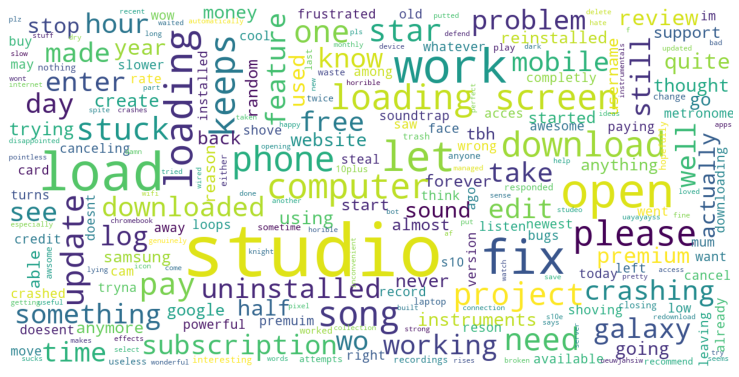

In [41]:
show_wordcloud1(september_2020.clean_sent)

In [42]:
#creating new variable with the data of the entire 2020
year_2020= df[df['year']=="2020"]
score_1_wordcloud= year_2020[year_2020.score ==1].sort_values(by='thumbsUpCount',ascending=False).head(15)
score_2_wordcloud= year_2020[year_2020.score ==2].sort_values(by='thumbsUpCount',ascending=False).head(15)
score_3_wordcloud= year_2020[year_2020.score ==3].sort_values(by='thumbsUpCount',ascending=False).head(15)
score_4_wordcloud= year_2020[year_2020.score ==4].sort_values(by='thumbsUpCount',ascending=False).head(15)
score_5_wordcloud= year_2020[year_2020.score ==5].sort_values(by='thumbsUpCount',ascending=False).head(15)


In [43]:
#score_1_wordcloud

In [44]:
#score_2_wordcloud

In [45]:
#score_3_wordcloud

In [46]:
#score_4_wordcloud

In [47]:
#score_5_wordcloud

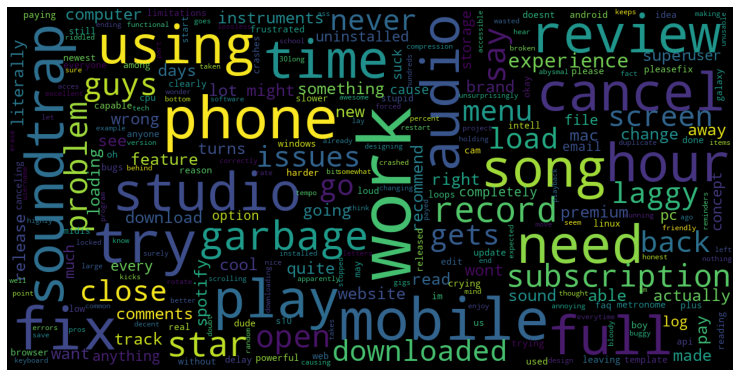

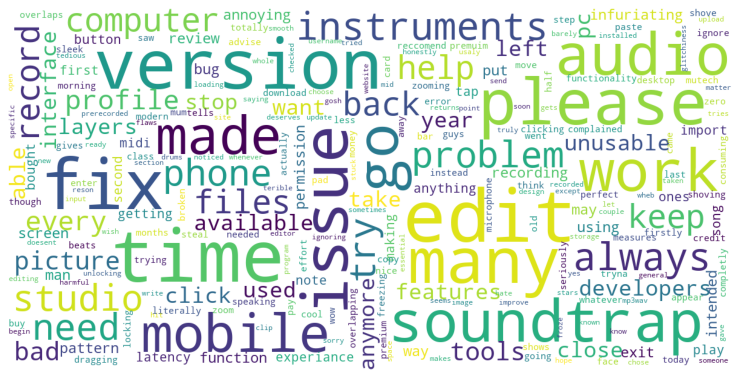

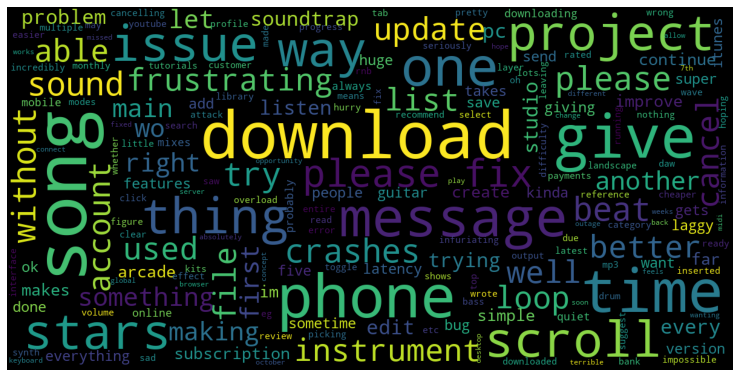

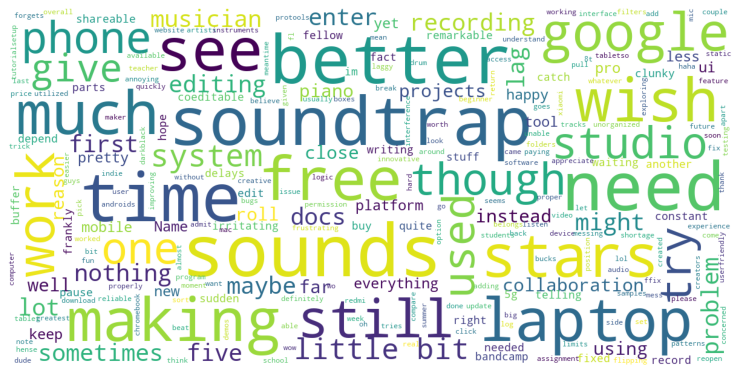

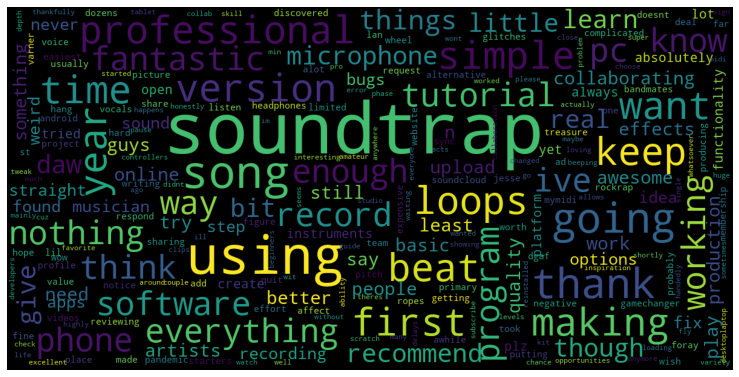

In [48]:
#printing the 1 word wordcloud groupped by score
show_wordcloud(score_1_wordcloud.clean_sent)
show_wordcloud1(score_2_wordcloud.clean_sent)
show_wordcloud(score_3_wordcloud.clean_sent)
show_wordcloud1(score_4_wordcloud.clean_sent)
show_wordcloud(score_5_wordcloud.clean_sent)


In [49]:
#filtering dataframe by date
df_filtered = year_2020
df_filtered_pos= df_filtered[df_filtered['score']>3].sort_values(by='thumbsUpCount',ascending=False).reset_index()
df_filtered_neg= df_filtered[df_filtered['score']<4].sort_values(by='thumbsUpCount',ascending=False).reset_index()
#df_filtered_neg

In [50]:
#filtering dataframe by date
df_filtered1 = df[df['year']=='2020']
#df_filtered_pos= df_filtered[df_filtered['score']>3].reset_index()
df_filtered_neg_2020= df_filtered[df_filtered['score']<4].reset_index()
len(df_filtered_neg_2020)

436

In [51]:
# joining the list of positive reviews into one big string
pos_text = df_filtered_pos.clean_sent
pos_text = ' '.join(pos_text)
#pos_text

In [52]:
# joining the list of negative reviews into one big string
neg_text = september_2020.clean_sent
neg_text = ' '.join(neg_text)
#neg_text

In [53]:
#Storing Text in two variables
Article_pos = pos_text
Article_neg = neg_text

In [54]:
#year 2020
#df_score_1 = df_score_1[df_score_1['month']>'2020-12']
#df_score_2 = df_score_2[df_score_2['year']=='2020']
#df_score_3 = df_score_3[df_score_3['year']=='2020']
#df_score_4 = df_score_4[df_score_4['year']=='2020']
#df_score_5 = df_score_5[df_score_5['year']=='2020']
len(df_filtered_neg)

436

In [55]:
Article_sep = september_2020.clean_sent
Article_sep = ''.join(pos_text)
#Article_sep

In [56]:
#SampleTextInBlobFormat.sentiment


In [57]:
#SampleTextInBlobFormat.polarity

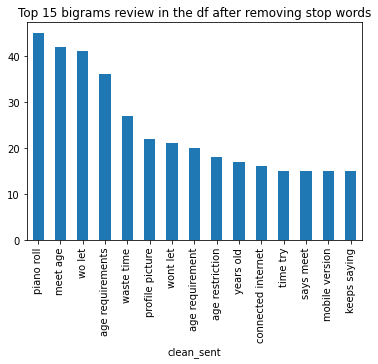

In [58]:
#dividing the string in ngrams and plot the most common ones
from sklearn.feature_extraction.text import CountVectorizer

def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(df_all_neg.clean_sent, 15)
#for word, freq in common_words:
    #print(word, freq)
df4 = pd.DataFrame(common_words, columns = ['clean_sent' , 'count'])
a = df4.groupby('clean_sent').sum()['count'].sort_values(ascending=False).plot(
kind='bar',title='Top 15 bigrams review in the df after removing stop words')

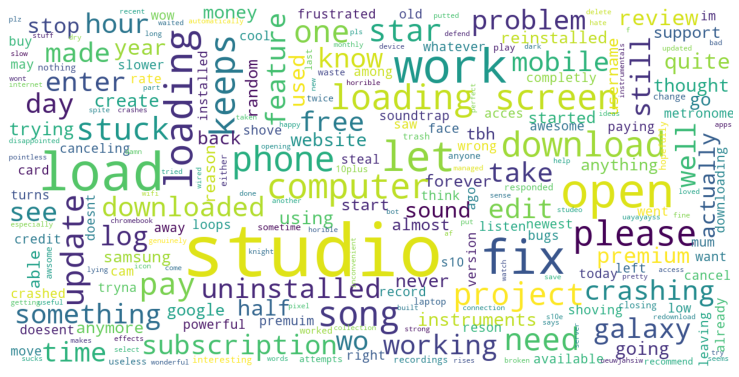

In [59]:
show_wordcloud1(september_2020.clean_sent)

In [60]:
september_2020['review_len'] = september_2020['content'].astype(str).apply(len)
september_2020['word_count'] = september_2020['content'].apply(lambda x: len(str(x).split()))
#september_2020.head()

In [61]:
SampleTextInBlobFormat = TextBlob(Article_neg)
 
# Finding the noun phrases (important keywords combination) in the text
# This can help to find out what entities are being talked about in the given text
NounPhrases=SampleTextInBlobFormat.noun_phrases
 
# Creating an empty list to hold new values
# combining the noun phrases using underscore to visualize it as wordcloud
NewNounList_neg=[]
for words in NounPhrases:
    NewNounList_neg.append(words.replace(" ", "_"))
    
# Converting list into a string to plot wordcloud
NewNounString_neg=' '.join(NewNounList_neg)
#print('##### Important word combinations ####')
#print(NewNounString_neg)

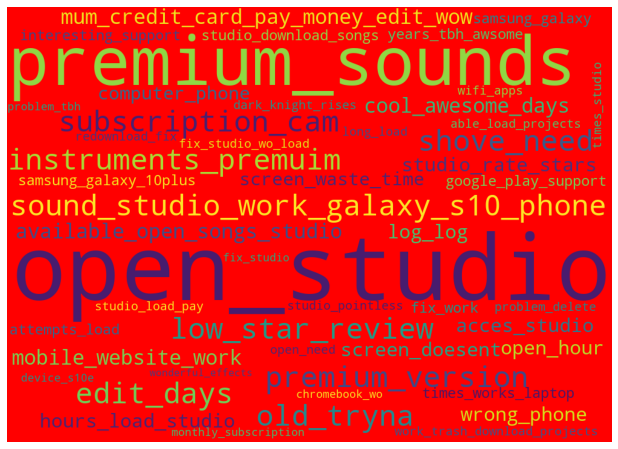

In [62]:
wordcloudimage = WordCloud( max_words=50,
                            font_step=2 ,
                            max_font_size=500,
                            #stopwords=customStopwords,
                            background_color='red',
                            width=1000,
                            height=720
                          ).generate(NewNounString_neg)
 
plt.figure(figsize=(20,8))
plt.imshow(wordcloudimage)
plt.axis("off")
plt.show()

# Project finished, after this point I will do some experiments

In [63]:
# Experimenting fuzzywuzzy

import pandas as pd
import numpy as np
from fuzzywuzzy import process, fuzz
ramen = september_2020
ramen.head()

C:\Users\albdip\Anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning:

Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning



index              userName                  at  score  thumbsUpCount  \
0      8  First name Last name 2020-09-22 03:50:11      1             78   
1   1607       TheTrashCanKing 2020-09-16 02:42:38      2             67   
2      7                 M. G. 2020-09-28 05:54:35      1             47   
4      9           Bking Heart 2020-09-22 15:35:13      1             31   
6   1595              Ell nell 2020-09-18 14:10:13      2             25   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      content  \
0                                                                                                 I've used this for quite a while now and even pay for the premium sounds. But ever since the newest update my sound studio will not work. I have a galaxy s10, its not like my phone isn't powerful. Leaving low star review and may cancel subscription if i can't use the features im paying for. EDIT: its been a few days now and still no fix. Canceling subscription until I cam actually use the app   
1  I love Soundtrap. BUT, can you stop shoving in the premium version in my face or whatever? Like i'm just some 12 year old tryna make some music and you just completly take that away from me because when i went on it today i saw you made like half of the instruments premuim. Stop trying to shove it in that i need to buy it to get this, get that, like i'm not going to steal my mum's credit card just so i can pay you her money. Edit: Wow they actually made the instruments available again.   
2                                                                                                                                                             I can't open any of my songs in the studio. I downloaded this because the metronome on the mobile website would not work (and no, I wasn't using loops), among other bugs because I'm on mobile. Then this turns out to be slower than the website. I'm so frustrated right now, I just want to record my music. This could be such a cool app.   
4                                                                                                                                                                                     So it was awesome but a few days ago ...the app crashed and doesn't let me acces to the studio it just keeps on loading ...i thought that something was wrong with my phone ....but i dont think so because i already uninstalled and installed again but its no use...i also log out and log back in but is the same..   
6                                                                                                                                                                                                                                                                                                                                                                                            For some reson when I go into the studio I get stuck on the loading screen it doesent even let me in the studio.   

        date    month  year         day  DoW  \
0 2020-09-01  2020-09  2020  2020-09-22    1   
1 2020-09-01  2020-09  2020  2020-09-16    2   
2 2020-09-01  2020-09  2020  2020-09-28    0   
4 2020-09-01  2020-09  2020  2020-09-22    1   
6 2020-09-01  2020-09  2020  2020-09-18    4   

                                                                                                                                                                                                                                                                                  

In [64]:
for col in ramen[['clean_sent']]:
    ramen[col] = ramen[col].str.strip()
    print('Number of unique values in ' + str(col) +': ' + str(ramen[col].nunique()))

Number of unique values in clean_sent: 53


In [65]:
unique_brand = ramen['clean_sent'].unique().tolist()
sorted(unique_brand)[:20]

['',
 'able log lame',
 'access studio computer phone inconvenient especially since phones mobile computers pretty',
 'awesome days ago crashed let acces studio keeps loading thought something wrong phone do not think already uninstalled installed also log log back',
 'built collection come back one day see half stuff part premiumsupreme category thanks lot guys',
 'create anything loading screen waste time',
 'doesnt well computer phone keeps loading get studio listen recordings worked computer',
 'dogshit',
 'download song without booting',
 'downloaded tried opening studio waited almost hour spite strong internet connection could',
 'enter studio downloaded try create something go enter studio pointless please fix',
 'f server slow',
 'fix studio function refund money',
 'get studio know broken',
 'get studio takes forever load change username recommend',
 'getting stuck enter studio loading screen',
 'going started crashing chromebook wo let save anything anymore know problem tbh',

In [66]:
#Create tuples of brand names, matched brand names, and the score
score_sort = [(x,) + i
             for x in unique_brand 
             for i in process.extract(x, unique_brand,     scorer=fuzz.token_sort_ratio)]
#Create a dataframe from the tuples
similarity_sort = pd.DataFrame(score_sort, columns=['brand_sort','match_sort','score_sort'])


In [67]:
similarity_sort

brand_sort  \
0    used quite pay premium sounds ever since newest update sound studio work galaxy s10 phone powerful leaving low star review may cancel subscription features im paying edit days still fix canceling subscription cam actually   
1    used quite pay premium sounds ever since newest update sound studio work galaxy s10 phone powerful leaving low star review may cancel subscription features im paying edit days still fix canceling subscription cam actually   
2    used quite pay premium sounds ever since newest update sound studio work galaxy s10 phone powerful leaving low star review may cancel subscription features im paying edit days still fix canceling subscription cam actually   
3    used quite pay premium sounds ever since newest update sound studio work galaxy s10 phone powerful leaving low star review may cancel subscription features im paying edit days still fix canceling subscription cam actually   
4    used quite pay premium sounds ever since newest update sound studio work galaxy s10 phone powerful leaving low star review may cancel subscription features im paying edit days still fix canceling subscription cam actually   
..                                                                                                                                                                                                                             ...   
260                                                                                                                                                                                                         nice need improvements   
261                                                                                                                                                                                                         nice need improvements   
262                                                                                                                                                                                                         nice need improvements   
263                                                                                                                                                                                                         nice need improvements   
264                                                                                                                                                                                                         nice need improvements   

                                                                                                                                                                                                                        match_sort  \
0    used quite pay premium sounds ever since newest update sound studio work galaxy s10 phone powerful leaving low star review may cancel subscription features im paying edit days still fix canceling subscription cam actually   
1                                                                                                                                       using quite sometime however since last update get studio download songs either please fix   
2                                                                               awesome days ago crashed let acces studio keeps loading thought something wrong phone do not think already uninstalled installed also log log back   
3                                                                                                           managed watch dark knight rises 3 times studio started genuinely lying loved see features start disappointed af 1 star   
4                                                                                                                never opens attempts load forever interesting support responded anyone google play support feature samsung galaxy   
..                                                                         

In [68]:
similarity_sort['sorted_brand_sort'] = np.minimum(similarity_sort['brand_sort'], similarity_sort['match_sort'])
similarity_sort.head()

brand_sort  \
0  used quite pay premium sounds ever since newest update sound studio work galaxy s10 phone powerful leaving low star review may cancel subscription features im paying edit days still fix canceling subscription cam actually   
1  used quite pay premium sounds ever since newest update sound studio work galaxy s10 phone powerful leaving low star review may cancel subscription features im paying edit days still fix canceling subscription cam actually   
2  used quite pay premium sounds ever since newest update sound studio work galaxy s10 phone powerful leaving low star review may cancel subscription features im paying edit days still fix canceling subscription cam actually   
3  used quite pay premium sounds ever since newest update sound studio work galaxy s10 phone powerful leaving low star review may cancel subscription features im paying edit days still fix canceling subscription cam actually   
4  used quite pay premium sounds ever since newest update sound studio work galaxy s10 phone powerful leaving low star review may cancel subscription features im paying edit days still fix canceling subscription cam actually   

                                                                                                                                                                                                                      match_sort  \
0  used quite pay premium sounds ever since newest update sound studio work galaxy s10 phone powerful leaving low star review may cancel subscription features im paying edit days still fix canceling subscription cam actually   
1                                                                                                                                     using quite sometime however since last update get studio download songs either please fix   
2                                                                             awesome days ago crashed let acces studio keeps loading thought something wrong phone do not think already uninstalled installed also log log back   
3                                                                                                         managed watch dark knight rises 3 times studio started genuinely lying loved see features start disappointed af 1 star   
4                                                                                                              never opens attempts load forever interesting support responded anyone google play support feature samsung galaxy   

   score_sort  \
0         100   
1          38   
2          37   
3          36   
4          34   

                                                                                                                                                                                                               sorted_brand_sort  
0  used quite pay premium sounds ever since newest update sound studio work galaxy s10 phone powerful leaving low star review may cancel subscription features im paying edit days still fix canceling subscription cam actually  
1  used quite pay premium sounds ever since newest update sound studio work galaxy s10 phone powerful leaving low star review may cancel subscription features im paying edit days still fix canceling subscription cam actually  
2                                                                             awesome days ago crashed let acces studio keeps loading thought something wrong phone do not think already uninstalled installed also log log back  
3                                                                                                         managed watch dark knight rises 3 times studio started genuinely lying loved see features start disappointed af 1 star  
4                                                                                                              never opens attempts load forever interesting support responded anyone google play support feature samsung galaxy

In [69]:
high_score_sort = similarity_sort[(similarity_sort['score_sort'] >= 50) &
                (similarity_sort['brand_sort'] !=  similarity_sort['match_sort']) &
                (similarity_sort['sorted_brand_sort'] != similarity_sort['match_sort'])]
high_score_sort = high_score_sort.drop('sorted_brand_sort',axis=1).copy()

In [70]:
t = high_score_sort.groupby(['brand_sort','score_sort']).agg(
                        {'match_sort': ', '.join}).sort_values(
                        ['score_sort'], ascending=False)

In [71]:
t = pd.DataFrame(t).reset_index()

In [72]:
#t

In [73]:
#export data to an excel file for further analysis
#df.to_excel (r'export_dataframe.xlsx', index = False, header=True)


In [74]:
#t.to_excel (r'match.xlsx', index = False, header=True)


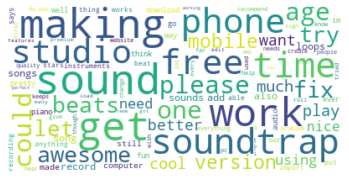

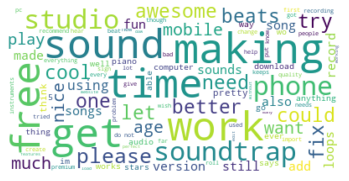

In [75]:
full_list = []# list containing all words of all texts
full_unique = []
for elmnt in df['Words_ok']:  # loop over lists in df
    full_list += elmnt  # append elements of lists to full list
    myset = set(elmnt)
    full_unique += list(myset)

from collections import Counter
word_could_dict=Counter(full_list)
word_could_dict_df= Counter(full_unique)

# a way to get insights from text is to use a wordcloud

#wordcloud on all words
from wordcloud import WordCloud, STOPWORDS
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate_from_frequencies(word_could_dict)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#wordcloud on unique words
from wordcloud import WordCloud, STOPWORDS
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate_from_frequencies(word_could_dict_df)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


In [76]:
"""albi_list = []# list containing all words of all texts
albi_unique = []
for elmnt in df_score_1['Words_ok']:  # loop over lists in df
    albi_list += elmnt  # append elements of lists to full list
    myset = set(elmnt)
    albi_unique += list(myset)

from collections import Counter
word_could_dict=Counter(albi_list)
word_could_dict_df= Counter(albi_unique)"""

"albi_list = []# list containing all words of all texts\nalbi_unique = []\nfor elmnt in df_score_1['Words_ok']:  # loop over lists in df\n    albi_list += elmnt  # append elements of lists to full list\n    myset = set(elmnt)\n    albi_unique += list(myset)\n\nfrom collections import Counter\nword_could_dict=Counter(albi_list)\nword_could_dict_df= Counter(albi_unique)"

In [77]:
"""#wordcloud on all words
from wordcloud import WordCloud, STOPWORDS
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate_from_frequencies(word_could_dict)
plt.figure(figsize=(20,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#wordcloud on unique words
from wordcloud import WordCloud, STOPWORDS
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate_from_frequencies(word_could_dict_df)
plt.figure(figsize=(20,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()"""


'#wordcloud on all words\nfrom wordcloud import WordCloud, STOPWORDS\nwordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate_from_frequencies(word_could_dict)\nplt.figure(figsize=(20,8))\nplt.imshow(wordcloud, interpolation="bilinear")\nplt.axis("off")\nplt.show()\n\n#wordcloud on unique words\nfrom wordcloud import WordCloud, STOPWORDS\nwordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate_from_frequencies(word_could_dict_df)\nplt.figure(figsize=(20,8))\nplt.imshow(wordcloud, interpolation="bilinear")\nplt.axis("off")\nplt.show()'

In [78]:
"""raw = Article_pos

# Given a string as input (`raw`), split it into sentences.
# Returns an object of type 'list: str'
sentences = nltk.sent_tokenize(raw)
# ['To Sherlock Holmes she is always the woman.',
# 'I have seldom heard him mention her under any other name.']

# Next, tokenize every sentence (string) in the list of sentences. The tokenizer takes
# strings as input so we need to apply it on each element of `sentences` (we can't apply
# it on the list itself). For that, we can use the function `map`, which applies any
# callable Python object to every element of a list.
# The output of this step will be an object of type
#   'list: list: str'
# such that
#   'sentences: sentence: word'
tokenized = map(nltk.tokenize.word_tokenize, sentences)
# [['To', 'Sherlock', 'Holmes', 'she', 'is', 'always', 'the', 'woman', '.'],
# ['I', 'have', 'seldom', 'heard', 'him', 'mention', 'her', 'under', 'any', 'other',
# 'name', '.']]

# We now generate the ngrams for each tokenized sentence in the list of sentences. Since
# we want to generate the ngrams for each sentence specifically, we again must apply the
# function to each element of the list separately, not the whole list. So, we use the
# `map` function again.
# The output of this step will be an object of type:
#   'list: list: tuple: <str, str>'
# such that
#   'sentences: sentence: ngram: <word_1, word_2>
bigrams = map(ngrams_wrapper, tokenized)
# [[('To', 'Sherlock'), ('Sherlock', 'Holmes'), ('Holmes', 'she'), ('she', 'is'), ('is',
# 'always'), ('always', 'the'), ('the', 'woman'), ('woman', '.')], [('I', 'have'),
# ('have', 'seldom'), ('seldom', 'heard'), ('heard', 'him'), ('him', 'mention'),
# ('mention', 'her'), ('her', 'under'), ('under', 'any'), ('any', 'other'), ('other',
# 'name'), ('name', '.')]]

# Finally, since we want all the bigrams in a single list to work with them more easily,
# we flatten the list, that is, we concatenate all the elements at the first level of
# depth in the list. So, if the list was an object of type
#   'list: list: tuple: <str, str>'  (sentences: sentence: ngram)
# we will transform it into:
#   'list: tuple: <str, str>'        (sentences: ngram)
bigram = list(itertools.chain.from_iterable(bigrams))
# [('To', 'Sherlock'), ('Sherlock', 'Holmes'), ('Holmes', 'she'), ('she', 'is'), ('is',
# 'always'), ('always', 'the'), ('the', 'woman'), ('woman', '.'), ('I', 'have'), ('have',
# 'seldom'), ('seldom', 'heard'), ('heard', 'him'), ('him', 'mention'), ('mention',
# 'her'), ('her', 'under'), ('under', 'any'), ('any', 'other'), ('other', 'name'),
# ('name', '.')]

freq_dist = nltk.FreqDist(bigram)
# [(('always', 'the'), 1), (('woman', '.'), 1), (('Holmes', 'she'), 1), (('seldom',
# 'heard'), 1), (('Sherlock', 'Holmes'), 1), (('him', 'mention'), 1), (('I', 'have'), 1),
# (('any', 'other'), 1), (('under', 'any'), 1), (('the', 'woman'), 1), (('her', 'under'),
# 1), (('other', 'name'), 1), (('To', 'Sherlock'), 1), (('name', '.'), 1), (('she', 'is'),
# 1), (('heard', 'him'), 1), (('mention', 'her'), 1), (('have', 'seldom'), 1), (('is',
# 'always'), 1)]

prob_dist = nltk.MLEProbDist(freq_dist)
number_of_bigrams = freq_dist.N()
bigram"""

"raw = Article_pos\n\n# Given a string as input (`raw`), split it into sentences.\n# Returns an object of type 'list: str'\nsentences = nltk.sent_tokenize(raw)\n# ['To Sherlock Holmes she is always the woman.',\n# 'I have seldom heard him mention her under any other name.']\n\n# Next, tokenize every sentence (string) in the list of sentences. The tokenizer takes\n# strings as input so we need to apply it on each element of `sentences` (we can't apply\n# it on the list itself). For that, we can use the function `map`, which applies any\n# callable Python object to every element of a list.\n# The output of this step will be an object of type\n#   'list: list: str'\n# such that\n#   'sentences: sentence: word'\ntokenized = map(nltk.tokenize.word_tokenize, sentences)\n# [['To', 'Sherlock', 'Holmes', 'she', 'is', 'always', 'the', 'woman', '.'],\n# ['I', 'have', 'seldom', 'heard', 'him', 'mention', 'her', 'under', 'any', 'other',\n# 'name', '.']]\n\n# We now generate the ngrams for each toke